In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from cxr_analysis import load_results_from_log, get_cxr14_rocs_from_log

/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/lfs/1/jdunnmon/repos/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Loading reproduce-chexnet data from file
reproduce_chexnet_results_path = '../analysis_data/reproduce_chexnet_aucs.csv'
reproduce_chexnet_results = pd.read_csv(reproduce_chexnet_results_path, 
                                        index_col='LABEL', names=['LABEL','CHEXNET-ORIG', 'CHEXNET-REPRODUCE'],
                                        header=0)
reproduce_chexnet_results.index = reproduce_chexnet_results.index.str.upper()

In [3]:
# Specify log directory to pull results from
log_base_dir = '/dfs/scratch0/jdunnmon/mmtl/results/cxr/logs_for_plotting'
logs_to_load = {
                'MTL-224':'baseline_chexnet_equivalent_results',
                'MTL-224-NO-DRAIN-BASE': 'new_drain_data_without_slice',
                'MTL-224-NO-DRAIN-HPS': 'new_drain_data_with_slice'
                #'MTL-224-DRAIN':'baseline_chexnet_equivalent_results_with_drain',
                #'MTL-512':'baseline_chexnet_equivalent_results_512', # GET WHEN FINISHED
                #'MTL-512-DRAIN':'baseline_chexnet_equivalent_results_with_drain_512',
                }

df_results_dict = {}
df_results_dict['roc-auc'] = reproduce_chexnet_results.copy()
df_results_dict['f1'] = reproduce_chexnet_results.copy()

for name, log in logs_to_load.items():
    # Loading all json logs
    results = load_results_from_log(os.path.join(log_base_dir,log))
    df_results_dict['roc-auc'] = get_cxr14_rocs_from_log(df_results_dict['roc-auc'], results['metrics'],
                                                         col_name=name, plot_metric='roc-auc', load_slices=False)
    df_results_dict['f1'] = get_cxr14_rocs_from_log(df_results_dict['f1'], results['metrics'], 
                                                    col_name=name, plot_metric='f1', load_slices=False)
    

In [6]:
df_results_dict['f1'].round(3)

,CHEXNET-ORIG,CHEXNET-REPRODUCE,MTL-224,MTL-224-NO-DRAIN-BASE,MTL-224-NO-DRAIN-HPS
LABEL,,,,,
ATELECTASIS,0.816,0.809,0.333,0.318,0.270
CARDIOMEGALY,0.910,0.925,0.372,0.376,0.374
CONSOLIDATION,0.801,0.790,0.014,0.002,0.018
EDEMA,0.898,0.888,0.103,0.061,0.117
EFFUSION,0.884,0.864,0.509,0.509,0.490
EMPHYSEMA,0.923,0.937,0.272,0.369,0.395
FIBROSIS,0.829,0.805,0.005,0.011,0.006
HERNIA,0.901,0.916,0.189,0.250,0.000
INFILTRATION,0.708,0.734,0.150,0.202,0.233


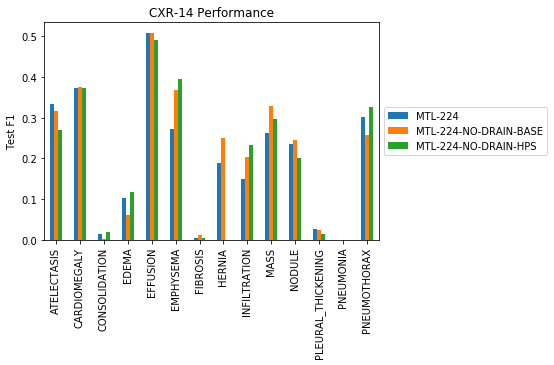

In [78]:
import matplotlib.pyplot as plt
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
#ax = df_compare.plot.bar(rot=45)
save_res = False
#models_to_plot = ['CHEXNET-ORIG','MTL-224','MTL-512']
models_to_plot = ['MTL-224','MTL-224-NO-DRAIN-BASE','MTL-224-NO-DRAIN-HPS']
plot_metric = 'f1'
df_plot = df_results_dict[plot_metric][models_to_plot]
f = plt.figure('ROC-AUC')
plt.title('CXR-14 Performance', color='black')
plt.ylabel(f'Test {plot_metric.upper()}')
plot = df_plot.plot(kind='bar', ax=f.gca(),rot=90)
plot.set_xlabel('')
if plot_metric == 'roc-auc':
    plot.set_ylim([0.7, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
if save_res:
    plt.savefig(f'../figures/CXR14-performance-{plot_metric}-mtl-chexnet-224-drain.png',format='png', bbox_inches='tight')
plt.show()

In [32]:
# Plotting drain slice performance
# (1) trained w/o slice: main head on main task
# (2) trained w/slice: main head on slice task, slice head on slice task

slice_results_dict = {}
slice_results_dict['f1'] = df_results_dict['f1'][models_to_plot].copy()

df_slice = {}
for ky, log in logs_to_load.items():
    results = load_results_from_log(os.path.join(log_base_dir,log))
    if 'slice_metrics' in results.keys():
        slice_metrics = results['slice_metrics']['test']
        for head in slice_metrics:
            slice_results_dict['f1'] = get_cxr14_rocs_from_log(slice_results_dict['f1'], 
                                        slice_metrics[head], col_name=f"{ky}", plot_metric='f1', load_slices=True, head=head)

In [33]:
slice_results_dict['f1']

,MTL-224,MTL-224-NO-DRAIN-BASE,MTL-224-NO-DRAIN-HPS
LABEL,,,
ATELECTASIS,0.333156,0.317777,0.270335
CARDIOMEGALY,0.372426,0.376203,0.373765
CONSOLIDATION,0.014257,0.002060,0.018072
EDEMA,0.102784,0.061404,0.116732
EFFUSION,0.509161,0.508579,0.490050
EMPHYSEMA,0.271787,0.369272,0.394507
FIBROSIS,0.005391,0.011142,0.005602
HERNIA,0.188679,0.250000,0.000000
INFILTRATION,0.149936,0.202487,0.232558


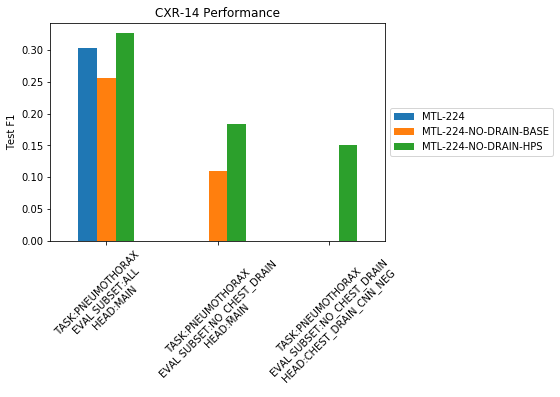

In [88]:
import matplotlib.pyplot as plt

def convert_slice_plot_names(df, slc_name):
    inds = df.index.tolist()
    for ii, ind in enumerate(inds):
        if ":" in ind:
            splt = ind.split(":")
            slc = slc_name
        else:
            splt = ind
            slc = 'ALL'
        if isinstance(splt, str):
            task, head = ind, 'MAIN'
        else:
            task, sh, head = splt
            if head == 'SLICE':
                head = sh
        inds[ii] = f'TASK:{task} \n EVAL SUBSET:{slc} \n HEAD:{head}'
    df.index = inds
    
# Save if True
save_res = True

# Getting models and tasks to plot
models_to_plot = ['MTL-224','MTL-224-NO-DRAIN-BASE','MTL-224-NO-DRAIN-HPS']
tasks_to_plot = ['PNEUMOTHORAX']
plot_metric = 'f1'
# Getting indices for all relevant slices
df_indices = [a for a in slice_results_dict[plot_metric].index if any([t in a for t in tasks_to_plot])]
# Selecting
df_plot = slice_results_dict[plot_metric][models_to_plot].loc[df_indices].copy()
# Converting names
convert_slice_plot_names(df_plot,'NO_CHEST_DRAIN')

f = plt.figure('DRAIN_SLICE')
plt.title('CXR-14 Performance', color='black')
plt.ylabel(f'Test {plot_metric.upper()}')
plot = df_plot.plot(kind='bar', ax=f.gca(),rot=45)
plot.set_xlabel('')
if plot_metric == 'roc-auc':
    plot.set_ylim([0.7, 1.0])
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
if save_res:
    plt.savefig(f'../figures/CXR14-performance-{plot_metric}-mtl-chexnet-224-pneumo-drain.png',format='png', bbox_inches='tight')
plt.show()

In [81]:
inds = df_plot.index.tolist()
for ii, ind in enumerate(inds):
    if ":" in ind:
        splt = ind.split(":")
    else:
        splt = ind
    if isinstance(splt, str):
        task, slc,head = ind, 'ALL', 'MAIN'
    else:
        task, slc, head = splt
    inds[ii] = f'TASK:{task} \n SLICE:{slc} \n HEAD:{head}'
        

ValueError: too many values to unpack (expected 3)

In [65]:
inds

['TASK:PNEUMOTHORAX \n SLICE:ALL \n HEAD:MAIN',
 'TASK:PNEUMOTHORAX \n SLICE:CHEST_DRAIN_CNN_NEG \n HEAD:MAIN',
 'TASK:PNEUMOTHORAX \n SLICE:CHEST_DRAIN_CNN_NEG \n HEAD:SLICE']